In [1]:
### since tsfresh is taking too long, and the condition of cloudy, we will focus on the creation of annual datasets
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import ee, eemont
from forestry_carbon_arr.core import ForestryCarbonARR
from forestry_carbon_arr.utils.zarr_utils import save_dataset_efficient_zarr, load_dataset_zarr

import gcsfs
import os

fs = gcsfs.GCSFileSystem(project=os.getenv("GOOGLE_CLOUD_PROJECT"), token='/usr/src/app/user_id.json')


forestry = ForestryCarbonARR(config_path='./00_input/korindo.json')
forestry.initialize_gee()

asset_mpc = forestry.config['mpc_monthly_col']
asset_gee = forestry.config['gee_monthly_col']

✓ GEE Initialized successfully
  Credentials Path: /usr/src/app/user_id.json - loaded successfully


In [3]:
# aoi
from forestry_carbon_arr.core.utils import DataUtils
import geopandas as gpd
import geemap

data_utils = DataUtils(forestry.config, use_gee=True)
aoi_gpd, aoi_ee = data_utils.load_geodataframe_gee(forestry.config["AOI_path"])

aoi_gpd_utm = aoi_gpd.to_crs(epsg=32749)

print(f"✅ AOI loaded: {len(aoi_gpd_utm)} features")
print(f"   Area: {aoi_gpd_utm.geometry.area.sum()/10000:.2f} hectares")

/opt/venv/lib/python3.12/site-packages/geemap/conversion.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


✅ AOI loaded: 1 features
   Area: 144217.67 hectares


In [4]:
## load the collections
gee_monthly_col = ee.ImageCollection(asset_gee)
mpc_monthly_col = ee.ImageCollection(asset_mpc)

mpc_monthly_col.first().bandNames().getInfo()

['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10', 'b11', 'b12']

In [5]:
zarr_path = forestry.config['mpc_zarr_monthly']
# zarr_path = 'data/ds_resampled.zarr'
# storage = 'local'
storage = 'gcs'

## dataset check
ds_sentinel_to_gee = load_dataset_zarr(zarr_path, storage=storage)
# ds_sentinel_to_gee
list_bands = list(ds_sentinel_to_gee.data_vars)
list_bands

📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/sentinel-2-l2a_korindo_2014-08-15_2018-01-31_gee_monthly.zarr
✅ Dataset loaded: {'time': 25, 'y': 3213, 'x': 4489}


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:833: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.dims)}")


['blue_median',
 'coastal_median',
 'green_median',
 'nir2_median',
 'nir_median',
 'red_median',
 'redE1_median',
 'redE2_median',
 'redE3_median',
 'redE4_median',
 'swir1_median',
 'swir2_median']

In [6]:
## MERGING THE ee.ImageCollections monthly
### Merging is needed for the approach in the project where cloud cover is too high

#gee_monthly_col is already scaled (/10000)
#mpc_monthly_col is not scaled
from forestry_carbon_arr.utils.gee_processing import rename_composite_bands
mpc_monthly_col_rename = mpc_monthly_col.map(lambda img: img.select(['b1', 'b2', 'b3', 'b4', 'b5', 
                                             'b6', 'b7', 'b8', 'b9', 'b10', 
                                             'b11', 'b12']).rename(list_bands))

mpc_monthly_col_rename = mpc_monthly_col_rename.map(lambda img: img.divide(10000))
aoi_ee_utm_geom = geemap.geopandas_to_ee(aoi_gpd_utm).geometry()
aoi_bounds_utm = aoi_ee_utm_geom.bounds(maxError=1)

# Rename bands: remove '_median' suffix and exclude 'cloudM_median'
mpc_monthly_col_monthly = rename_composite_bands(
    mpc_monthly_col_rename,
    remove_suffix='_median',
    exclude_bands=['coastal_median', 'nir2_median']
)

mpc_monthly_col_monthly = mpc_monthly_col_monthly.map(
    lambda img: img.set(
        'system:time_start',
        ee.Date.fromYMD(
            ee.Number.parse(ee.String(img.get('system:index')).replace('Sentinel2_', '').split('_').get(0), 10),
            ee.Number.parse(ee.String(img.get('system:index')).replace('Sentinel2_', '').split('_').get(1), 10),
            15
        ).millis()
    )
)

gee_monthly_col_monthly = rename_composite_bands(
    gee_monthly_col,
    remove_suffix='_median',
    exclude_bands=['cloudM_median']
)

print('mpc_band names: ',mpc_monthly_col_monthly.first().bandNames().getInfo())
print('gee_band names: ',gee_monthly_col_monthly.first().bandNames().getInfo())

print('mpc_band property: ', mpc_monthly_col_monthly.first().propertyNames().getInfo())
print('gee_band property: ', gee_monthly_col_monthly.first().propertyNames().getInfo())


#merge the two collections
merged_col = ee.ImageCollection(mpc_monthly_col_monthly.merge(gee_monthly_col_monthly))
print('merged col bandNames: ', merged_col.first().bandNames().getInfo())
print('merged col propertyNames: ', merged_col.first().propertyNames().getInfo())


mpc_band names:  ['blue', 'green', 'nir', 'red', 'redE1', 'redE2', 'redE3', 'redE4', 'swir1', 'swir2']
gee_band names:  ['blue', 'green', 'red', 'redE1', 'redE2', 'redE3', 'nir', 'redE4', 'swir1', 'swir2']
mpc_band property:  ['system:time_start', 'system:footprint', 'system:index', 'system:bands', 'system:band_names']
gee_band property:  ['system:time_start', 'n_images', 'month', 'year', 'system:footprint', 'system:version', 'system:id', 'system:asset_size', 'system:index', 'system:bands', 'system:band_names']
merged col bandNames:  ['blue', 'green', 'nir', 'red', 'redE1', 'redE2', 'redE3', 'redE4', 'swir1', 'swir2']
merged col propertyNames:  ['system:time_start', 'system:footprint', 'system:index', 'system:bands', 'system:band_names']


In [7]:
### executing the smoothing for the indices
# STEP 5: Add spectral indices and apply smoothing
print("\n" + "=" * 60)
print("STEP 5: Add spectral indices and apply smoothing")
print("=" * 60)

from forestry_carbon_arr.utils.gee_processing import process_collection_with_indices_and_smoothing, remove_drops_and_spikes_gee

collection_with_sg = process_collection_with_indices_and_smoothing(
    collection=merged_col,
    config=forestry.config,
    aoi_ee=aoi_ee,
    spectral_bands=['blue', 'green', 'nir', 'red', 'redE1', 'redE2', 'redE3', 'redE4', 'swir1', 'swir2'],
    smoothing_window=1,  
    smoothing_polyorder=2,
    add_fcd=False,
    outlier_window= 5,
    outlier_threshold = 0.2
)

print(f"✅ Final collection: {collection_with_sg.size().getInfo()} images")
band_names_sg = collection_with_sg.first().bandNames().getInfo()
print(f"   Bands: {band_names_sg}")


STEP 5: Add spectral indices and apply smoothing
✅ Final collection: 106 images
   Bands: ['blue', 'green', 'nir', 'red', 'redE1', 'redE2', 'redE3', 'redE4', 'swir1', 'swir2']


In [8]:
from forestry_carbon_arr.utils import fill_temporal_gaps_linear

# Use on your SG-smoothed collection
bands_to_fill = ['blue', 'green', 'nir', 'red', 'redE1', 'redE2', 'redE3', 'redE4', 'swir1', 'swir2']  # or the bands you smoothed
collection_monthly_filled = fill_temporal_gaps_linear(collection_with_sg, bands_to_fill)

print('Original monthly (with NaNs):', collection_with_sg.size().getInfo())
print('Filled monthly collection:', collection_monthly_filled.size().getInfo())

Original monthly (with NaNs): 106
Filled monthly collection: 106


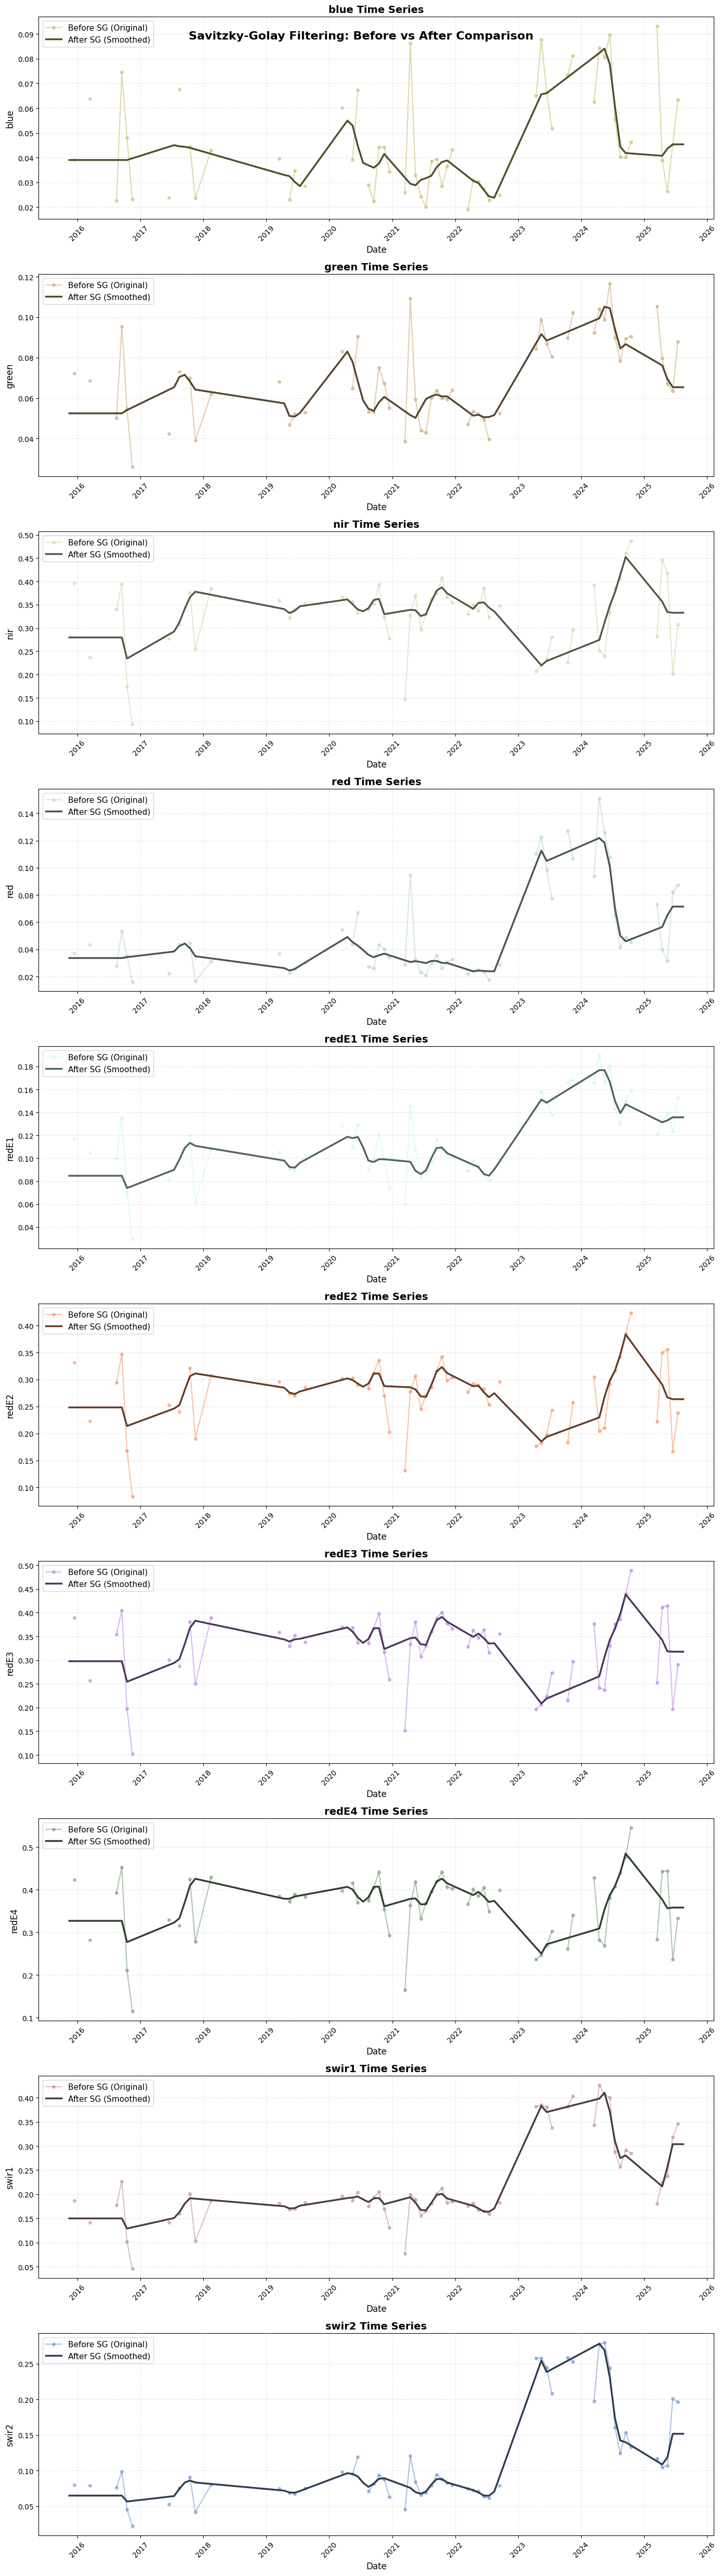

In [9]:
from forestry_carbon_arr.utils.gee_processing import (
    extract_time_series_for_visualization,
    plot_sg_comparison
)

# Extract time series
sample_point = ee.Geometry.Point([111.81746, -0.41587])
bands = bands_to_fill

df_before, df_after = extract_time_series_for_visualization(
    collection_before=merged_col,
    collection_after=collection_monthly_filled,
    sample_point=sample_point,
    bands=bands,
    # time_dates=time_dates_source,  # Optional: from zarr dataset
    scale=10
)

# Plot comparison
plot_sg_comparison(df_before, df_after, bands)

In [ ]:
### exporting to gee asset:
# Get the list of images
image_list = collection.toList(collection.size())
n_images = image_list.size().getInfo()

# Export each image
tasks = []
for i in range(n_images):
    image = ee.Image(image_list.get(i))
    
    # Get image ID or create one
    image_id = image.get('system:id').getInfo() or f'image_{i}'
    
    # Define export parameters
    export_params = {
        'image': image,
        'description': f'export_{image_id}',
        'assetId': f'projects/your-project/assets/your-folder/{image_id}',
        'scale': 10,  # Adjust as needed
        'region': your_region.geometry(),  # Optional: specify region
        'maxPixels': 1e13
    }
    
    # Create and start export task
    task = ee.batch.Export.image.toAsset(**export_params)
    task.start()
    tasks.append(task)
    
    print(f'Started export task {i+1}/{n_images}: {image_id}')

# Monitor tasks (optional)
for task in tasks:
    while task.status()['state'] in ['READY', 'RUNNING']:
        print(f'Task {task.id}: {task.status()}')
        time.sleep(5)
    print(f'Task {task.id} completed: {task.status()}')